In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from scipy.signal import lsim
from scipy.integrate import solve_ivp
import opentorsion as ot
import cvxpy as cp

In [2]:
def propulsion_system():
    '''
    Parameters from: https://journals.sagepub.com/doi/full/10.1177/14759217211004232
    '''
    J1 = 1.347e4 # propeller
    J3 = 5.590e2
    J5 = 5.120e2
    J7 = 4.870e2
    J9 = 1.410e2
    J11 = 1.740e2
    J13 = 4.415e3 # motor
    
    k2 = 5.88e7
    k4 = 5.95e7
    k6 = 1.12e8
    k8 = 6.93e8
    k10 = 5.09e8
    k12 = 1.43e8
    damping = 1800 # damping in steel_shafts
    propeller_damping = 120e3
    
    shafts, disks = [], []
    disks.append(ot.Disk(0, I=J1, c=propeller_damping))
    shafts.append(ot.Shaft(0, 1, None, None, k=k2, I=0, c=damping))
    disks.append(ot.Disk(1, I=J3))
    shafts.append(ot.Shaft(1, 2, None, None, k=k4, I=0, c=damping))
    disks.append(ot.Disk(2, I=J5))
    shafts.append(ot.Shaft(2, 3, None, None, k=k6, I=0, c=damping))
    disks.append(ot.Disk(3, I=J7))
    shafts.append(ot.Shaft(3, 4, None, None, k=k8, I=0, c=damping))
    disks.append(ot.Disk(4, I=J9))
    shafts.append(ot.Shaft(4, 5, None, None, k=k10, I=0, c=damping))
    disks.append(ot.Disk(5, I=J11))
    shafts.append(ot.Shaft(5, 6, None, None, k=k12, I=0, c=damping))
    disks.append(ot.Disk(6, I=J13))
    
    assembly = ot.Assembly(shafts, disk_elements=disks)
    _, f, _ = assembly.modal_analysis()
    print("Eigenfrequencies: ", f.round(2))

    return assembly

In [3]:
def state_matrices(assembly):
    """
    Create state-space matrices A and B of an openTorsion assembly.

    Parameters:
    assembly : openTorsion assembly instance
        Mechanical drivetrain model.

    Returns:
    A : numpy.ndarray
        The state matrix
    B : numpy.ndarray
        The input matrix
    """
    M, C, K = assembly.M(), assembly.C(), assembly.K()  # Mass and stiffness matrices
    # C = assembly.C_modal(M, K, xi=0.02)  # Modal damping matrix, modal damping coefficient 0.02 used
    Z = np.zeros(M.shape)
    I = np.eye(M.shape[0])
    M_inv = LA.inv(M)

    A = np.vstack([np.hstack([Z, I]), np.hstack([-M_inv @ K, -M_inv @ C])])

    B = np.vstack([Z, M_inv])

    return A, B

In [4]:
def O(A, C, n):
    '''
    Create the extended observability matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    O : numpy.ndarray, shape(n, number of state variables)
        The extended observability matrix
    '''
    O = np.copy(C)
    for k in range(1, n):
        O = np.vstack((O, C @ np.linalg.matrix_power(A, k)))

    return O

In [29]:
def gamma(A, B, C, n):
    '''
    Create the impulse response matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    gamma : numpy.ndarray, shape(n*number of state variables, n*number of state variables)
        The impulse response matrix
    '''
    # first column
    gamma_column_first = np.zeros((C @ B).shape)
    for k in range(1, n):
        gamma_column_first = np.vstack((gamma_column_first, C @ np.linalg.matrix_power(A, k) @ B))

    # build complete matrix
    gamma = gamma_column_first
    current_col = 1
    for s in range(1, n):
        gamma_rows = np.zeros((C @ B).shape)
        for z in range(1, current_col):
            row_val = np.zeros((C @ B).shape)
            gamma_rows = np.vstack((gamma_rows, row_val))
        for nz in range(n-current_col):
            row_val = C @ np.linalg.matrix_power(A, nz) @ B
            gamma_rows = np.vstack((gamma_rows, row_val))

        gamma = np.hstack((gamma, gamma_rows))
        current_col += 1

    return gamma

In [119]:
def L(input_shape):
    '''
    The regularization matrix L.

    Parameters:

    meas_shape : float
        Input vector shape used to determine L matrix shape.

    Returns:

    L : ndarray
        The regularization matrix
    '''
    I = np.eye(input_shape)
    L = -I + np.diag(np.ones(input_shape-1), 1)

    return I

In [120]:
def convex_optimization_problem(meas, gamma, L, lam=0.0512):
    '''
    Convex optimization methods using the cvxpy library.
    '''
    d = cp.Variable((gamma.shape[1], 1), complex=False)
    x = 0
    print(meas.shape)
    print((gamma @ d).shape)
    # objective = cp.Minimize(cp.sum_squares(meas - O @ x - gamma @ d) + lam * cp.pnorm(L @ d, 1))
    objective = cp.Minimize(cp.sum_squares(meas - gamma @ d) + lam * cp.sum_squares(L @ d))
    prob = cp.Problem(objective)
    prob.solve(solver=cp.SCS)

    return prob.value

In [121]:
assembly = propulsion_system()
A, B = state_matrices(assembly)
C = np.eye(B.shape[0])
D = np.zeros(B.shape)

Eigenfrequencies:  [0.0000000e+00 9.5200000e+00 9.5200000e+00 4.8520000e+01 4.8520000e+01
 7.8630000e+01 7.8630000e+01 1.1526000e+02 1.1526000e+02 2.6861000e+02
 2.6861000e+02 5.2280000e+02 5.2280000e+02 1.7014339e+05]


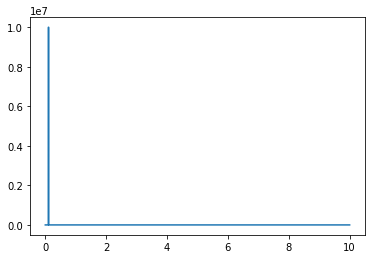

In [125]:
t = np.arange(0, 10.001, 0.001)

# impulse applied at node 0
u = np.zeros((len(t), 7))
u[100:110,0] = 1e7

tout, yout, xout = lsim((A, B, C, D), u, t)

torque_meas = 6.93e8*(yout[:,4]-yout[:,3])
y = yout[130:150,3:5]

plt.plot(t, u[:,0])
plt.show()

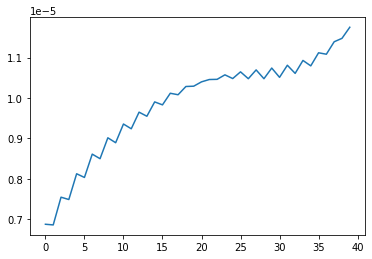

In [126]:
measurement = np.vstack([y[0,0], y[0,1]])
for i in range(1, y.shape[0]):
    measurement = np.vstack([measurement, y[i,0], y[i,1]])

plt.plot(measurement)
plt.show()

In [127]:
n = 20 # number of measurements in the batch
gam = gamma(A, B, np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]), n)
reg = L(7*n) # size: number of nodes times number of timesteps
estimate = convex_optimization_problem(measurement, gam, reg)
print(estimate)

(40, 1)
(40, 1)
3.880888358249632e+70


/u/60/hakoneu1/unix/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
